In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

ens2Z_1d_V={'b':1.1262,'c':1.1573,'d':1.1930,'e':1.2175}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2amus={'b':0.0186}
ens2amuc={'b':0.249}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens2tfs={'b':range(2,26+1),'c':range(2,28+1),'d':range(2,32+1),'e':range(2,32+1)}

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

# ens='b'
# ens2a[ens]*hbarc*1000

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

In [2]:
data={}

t_data=['data1','data2','data3','data4']
fla='js'
for ens in ['c']:
    data[ens]={}
    tfs=range(2,20+1,2)
    
    path=f'/p/project/ngff/li47/code/projectData/02_discNJN_1D/{ens2full[ens]}/data_earlytest/test_scalingCheck.h5'
    with h5py.File(path) as f:
        data[ens]['N0']=f['N_mom0'][:]
        data[ens]['N1']=f['N_mom1'][:]
        
        for stoc in t_data:
            data[ens][stoc]={}
            for tf in tfs:
                data[ens][stoc][tf]=f[f'{stoc}/{fla}/P4i(G0,pi,pi)/{tf}'][:]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/p/project/ngff/li47/code/projectData/02_discNJN_1D/cC211.060.80/data_earlytest/test_scalingCheck.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [110]:
path='/p/project/ngff/li47/code/projectData/02_discNJN_1D/cC211.060.80/data_earlytest/test.h5'
with h5py.File(path) as f:
    print(f['js/P4i(G0,pi,pi)'].keys())
    
    t1=f['js/P4i(G0,pi,pi)/10'][:]
    t2=np.mean(np.mean([data['c'][stoc][10] for stoc in t_data[:4]],axis=0),axis=1)
    dt=t1-t2
    print(np.max(np.abs(dt)))
    print(np.max(np.abs(t1)))

<KeysViewHDF5 ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '3', '4', '5', '6', '7', '8', '9']>
5.463605905714139e-18
6.8452391792439664e-12


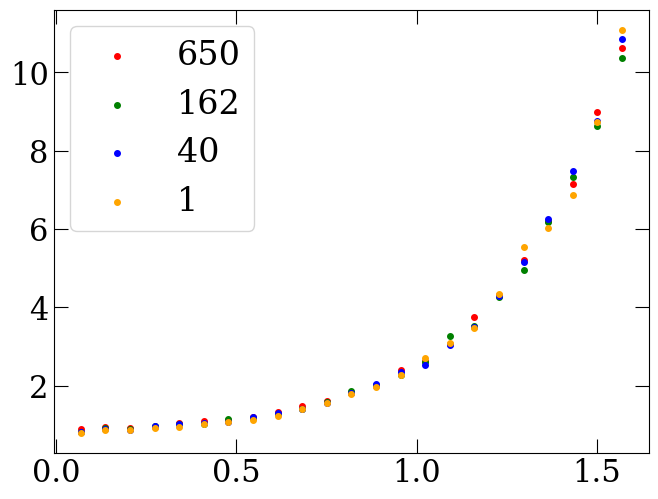

In [3]:
ens='c'
Nsrcs=[650,650//4,650//16,1]
Nsrc0=650
colors=['r','g','b','orange']

fix, axs = yu.getFigAxs(1,1,sharey=True)
xunit=ens2a[ens]; yunit=ens2aInv[ens]
ax=axs[0,0]
# ax.set_ylim([0,10])
for i_nsrc,Nsrc in enumerate(Nsrcs):
    t=np.mean(data[ens]['N1'][:,:Nsrc],axis=1)
    cN=yu.jackknife(t)
    func=lambda c:np.log(c/np.roll(c,-1))
    meff=yu.jackmap(func,cN)
    mean,err=yu.jackme(meff)
    
    tmin=1; tmax=24
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=err[tmin:tmax]*yunit*np.sqrt(Nsrc/Nsrc0)
    ax.scatter(plt_x,plt_y,color=colors[i_nsrc],label=Nsrc)
    
ax.legend()

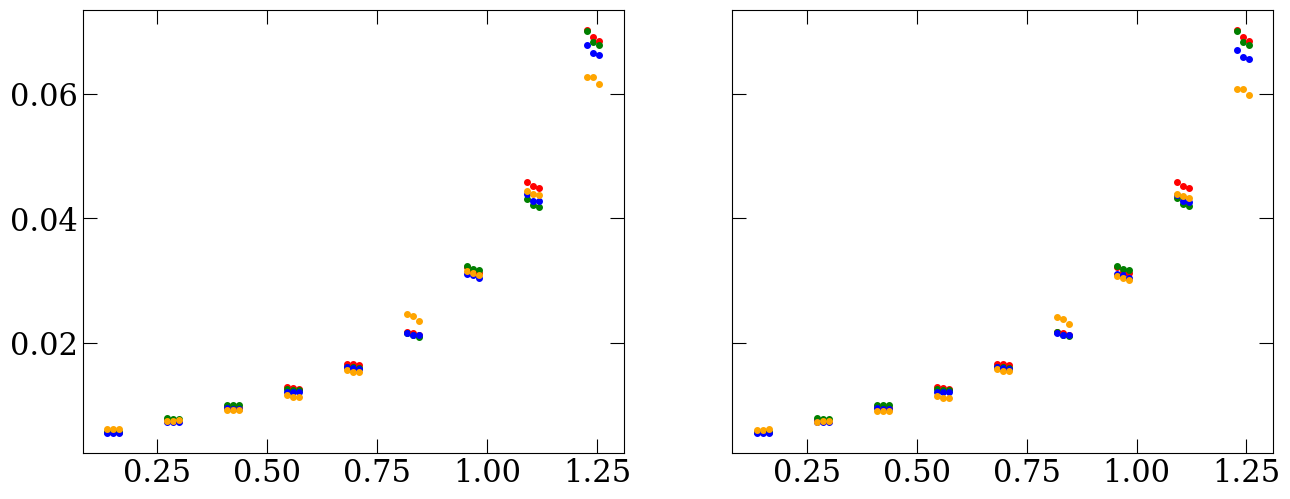

In [15]:
ens='c'
Nsrcs=[650,650//4,650//16,1]
Nsrc0=650
colors=['r','g','b','orange']

fix, axs = yu.getFigAxs(1,2,sharey=True)
xunit=ens2a[ens]; yunit=ens2aInv[ens]
ax=axs[0,0]
# ax.set_ylim([0,10])

for i_stoc,Nstoc in enumerate([1,2,4]):
    for i_nsrc,Nsrc in enumerate(Nsrcs):
        t=np.mean(data[ens]['N1'][:,:Nsrc],axis=1)
        c2pt=yu.jackknife(t)
        
        for tf in range(2,18+1,2):
            t=np.mean(np.mean([data[ens][stoc][tf][:,:Nsrc] for stoc in t_data[:Nstoc]],axis=0),axis=1)
            t=np.real(t/(1j*2*np.pi/ens2N[ens]))
            c3pt=yu.jackknife(t)
            ratio=c3pt/c2pt[:,tf:tf+1]
            
            mean,err=yu.jackme(ratio)
            
            # tmin=1; tmax=24
            plt_x=np.array([tf+i_stoc*0.2])*xunit; plt_y=err[tf//2]*np.sqrt(Nsrc/Nsrc0)
            ax.scatter(plt_x,plt_y,color=colors[i_nsrc])
            
ax=axs[0,1]
# ax.set_ylim([0,10])

for i_stoc,Nstoc in enumerate([1,2,4]):
    for i_nsrc,Nsrc in enumerate(Nsrcs):
        t=np.mean(data[ens]['N1'][:,:],axis=1)
        c2pt=yu.jackknife(t)
        
        for tf in range(2,18+1,2):
            t=np.mean(np.mean([data[ens][stoc][tf][:,:Nsrc] for stoc in t_data[:Nstoc]],axis=0),axis=1)
            t=np.real(t/(1j*2*np.pi/ens2N[ens]))
            c3pt=yu.jackknife(t)
            ratio=c3pt/c2pt[:,tf:tf+1]
            
            mean,err=yu.jackme(ratio)
            
            # tmin=1; tmax=24
            plt_x=np.array([tf+i_stoc*0.2])*xunit; plt_y=err[tf//2]*np.sqrt(Nsrc/Nsrc0)
            ax.scatter(plt_x,plt_y,color=colors[i_nsrc])

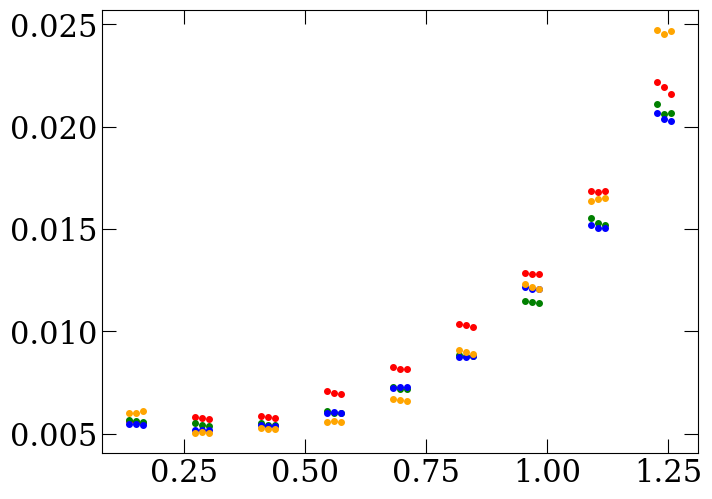

In [111]:
ens='c'
Nsrcs=[650,650//4,650//16,1]
Nsrc0=650
colors=['r','g','b','orange']

fix, axs = yu.getFigAxs(1,1,sharey=True)
xunit=ens2a[ens]; yunit=ens2aInv[ens]
ax=axs[0,0]
# ax.set_ylim([0,10])

for i_stoc,Nstoc in enumerate([1,2,4]):
    for i_nsrc,Nsrc in enumerate(Nsrcs):
        t=np.mean(data[ens]['N1'][:,:Nsrc],axis=1)
        c2pt=yu.jackknife(t)
        
        for tf in range(2,18+1,2):
            t=np.mean(np.mean([data[ens][stoc][tf][:,:Nsrc] for stoc in t_data[:Nstoc]],axis=0),axis=1)
            t=np.real(t/(1j*2*np.pi/ens2N[ens]))
            c3pt=yu.jackknife(t)
            ratio=c3pt/c2pt[:,tf:tf+1]
            ratio=np.mean(ratio[:,1:tf],axis=1)
            
            mean,err=yu.jackme(ratio)
            
            # tmin=1; tmax=24
            plt_x=np.array([tf+i_stoc*0.2])*xunit; plt_y=err*np.sqrt(Nsrc/Nsrc0)
            ax.scatter(plt_x,plt_y,color=colors[i_nsrc])

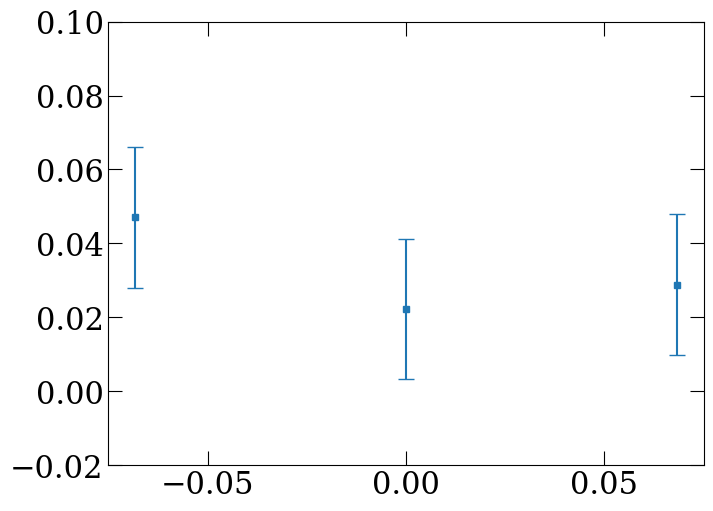

In [76]:
ens='c'
Nsrcs=[650,650//4,650//16]
Nsrc0=650
colors=['r','g','b']

fix, axs = yu.getFigAxs(1,1,sharey=True)
xunit=ens2a[ens]; yunit=ens2aInv[ens]*1.1573
ax=axs[0,0]
ax.set_ylim([-0.02,0.1])

for i_stoc,Nstoc in enumerate([4]):
    for i_nsrc,Nsrc in enumerate([100]):
        t=np.real(np.mean(data[ens]['N1'][:,:Nsrc],axis=1))
        c2pt=yu.jackknife(t)
        
        for tf in range(4,4+1,2):
            t=np.mean(np.mean([data[ens][stoc][tf][:,:Nsrc] for stoc in t_data[:Nstoc]],axis=0),axis=1)
            c3pt=np.real(yu.jackknife(t)/(1j*2*np.pi/ens2N[ens]))
            ratio=c3pt/c2pt[:,tf:tf+1]
            
            mean,err=yu.jackme(ratio)
            
            # tmin=1; tmax=24
            tcs=np.arange(1,tf)
            plt_x=(tcs-tf/2)*xunit; plt_y=mean[1:tf]; plt_yerr=err[1:tf]
            ax.errorbar(plt_x,plt_y,plt_yerr)

In [5]:
data={}
enss=['b','c','d','e']
flas=['j+','js','jc'][1:2]
for ens in enss:
    print(ens)
    data[ens]={}
    tfs=ens2tfs[ens]

    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/{ens2full[ens]}/data_earlytest/test.h5'
    with h5py.File(path) as f:
        data[ens]['N0']=f['N_mom0'][:]
        data[ens]['N1']=f['N_mom1'][:]
        
        data[ens]['P44']={}
        data[ens]['P4i']={}
        for fla in flas:
            data[ens]['P44'][fla]={}
            data[ens]['P4i'][fla]={}
            for tf in tfs:
                data[ens]['P44'][fla][tf]=f[f'{fla}/P44(G0,0,0)/{tf}'][:]
                data[ens]['P4i'][fla][tf]=f[f'{fla}/P4i(G0,pi,pi)/{tf}'][:]

b
c
d
e


rescaled ratio

needs factor (1/NL or a)^(5 or 6) for the variance~error^2 to match 

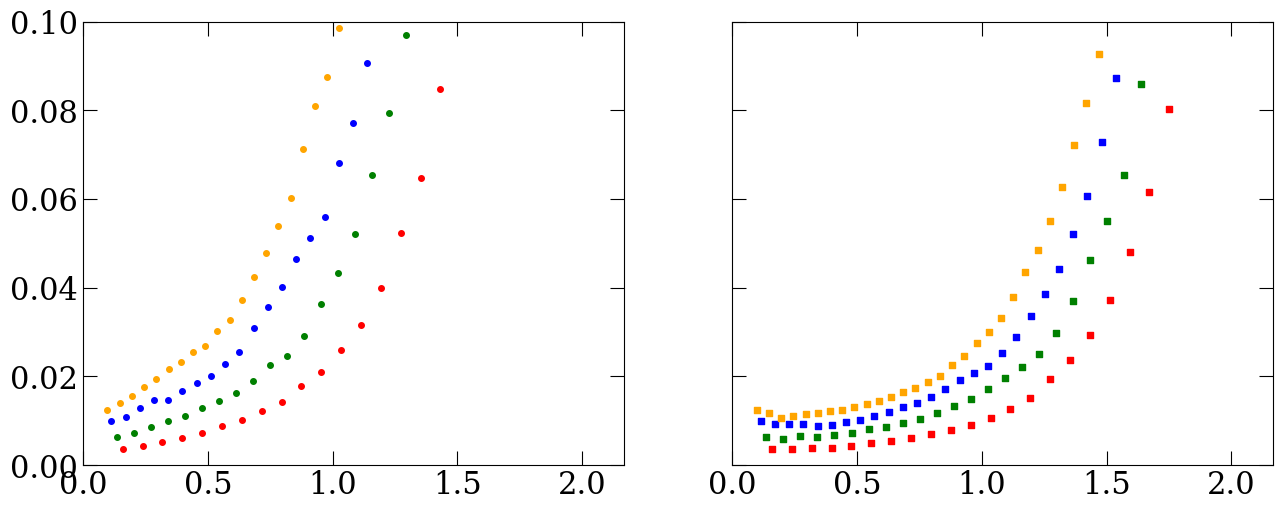

In [45]:
Nsrcs=np.array([200+85+64,650,256+112,100])
Ncfgs=np.array([743,400,494,516])
# Ncfgs=np.array([400,400,400,400])
stats=Nsrcs[:len(enss)]*Ncfgs[:len(enss)]
# stats=Nsrcs*Ncfgs/(np.array([64,80,96,112])**6)
# stats=Nsrcs[:len(enss)]*Ncfgs[:len(enss)]*(np.array([ens2a[ens] for ens in enss])**6)
rescales=np.sqrt(stats/stats[0])
# rescales=[1,1,1,1]

ens2Z=ens2Z_1d_V; j='js'
fix, axs = yu.getFigAxs(1,2,sharey=True)
threshold=0.05
colors=['r','g','b','orange']
for i_ens,ens in enumerate(enss):
    Ncfg=Ncfgs[i_ens]
    xunit=ens2a[ens]
    tfs=ens2tfs[ens]
    cN1=np.real(yu.jackknife(data[ens]['N1'][:Ncfg]))
    c3ptDic={tf:np.real(yu.jackknife(data[ens]['P4i'][j][tf][:Ncfg])/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}
    
    ax=axs[0,0]; color=colors[i_ens]
    for i_tf,tf in enumerate(tfs):
        # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        mean,err=yu.jackme(ratioDic[tf][:,tf//2])
        plt_y=err*ens2Z[ens]*rescales[i_ens]
        ax.scatter(tf*xunit,plt_y, color=color, marker='o')
    
    ax=axs[0,1]; color=colors[i_ens]
    for i_tf,tf in enumerate(tfs):
        tcmin=1
        if tf-tcmin+1>tcmin:
            t=ratioDic[tf][:,tcmin:(tf-tcmin+1)]
            Ndata=t.shape[1]
            mean,err=yu.jackme(np.mean(t,axis=1))
            plt_y=err*ens2Z[ens]*rescales[i_ens]
            ax.scatter(tf*xunit,plt_y, color=color, marker='s')
            
            # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
            # plt_y=err*ens2Z[ens]/np.sqrt(Ndata)
            # ax.scatter(tf,plt_y, color=color, marker='d')
            
    # ax.set_yscale('log')
    ax.set_ylim([0,0.1])

B performs better even using 400 cfgs for all ensembles

smearing?

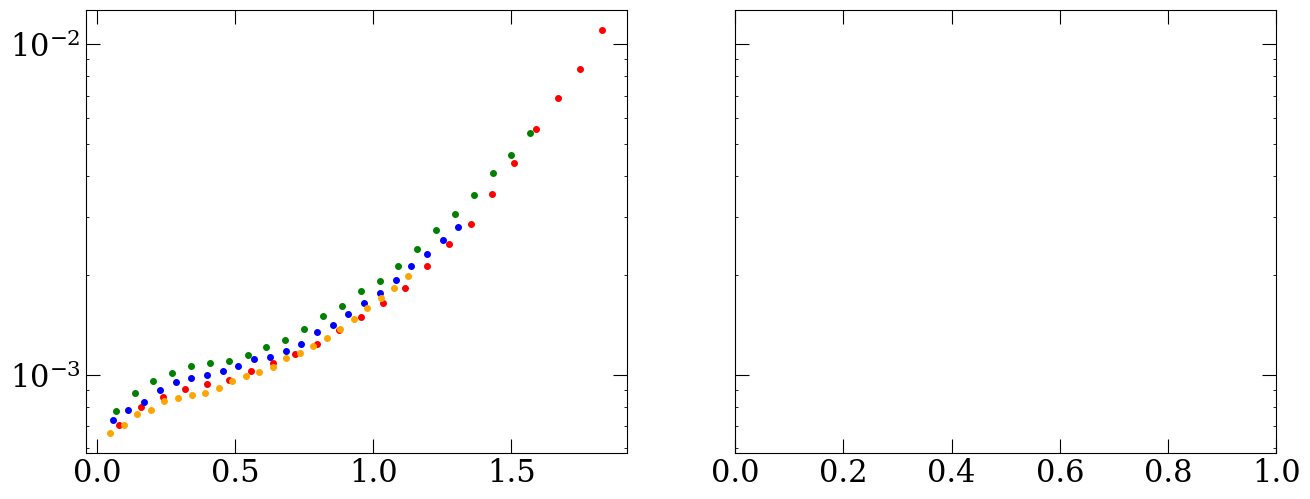

In [9]:
Nsrcs=np.array([200+85+64,650,256+112,100])
Ncfgs=np.array([743,400,494,516])
# Ncfgs=np.array([400,400,400,400])
stats=Nsrcs*Ncfgs
rescales=np.sqrt(stats/stats[1])
# rescales=[1,1,1,1]

fix, axs = yu.getFigAxs(1,2,sharey=True)
ax=axs[0,0]
# ax.set_ylim([0,5])
# ax.set_ylim([900,1000])
colors=['r','g','b','orange']
for i_ens,ens in enumerate(enss):
    Ncfg=Ncfgs[i_ens]
    xunit=ens2a[ens]
    tfs=ens2tfs[ens]
    cN0=np.real(yu.jackknife(data[ens]['N0'][:Ncfg]))
    func=lambda c:np.log(c/np.roll(c,-1))
    # meff=yu.jackmap(func,cN0)
    rcN0=cN0[:,:]
    # print(meff.shape)
    
    color=colors[i_ens]
    for i_tf,tf in enumerate(range(1,24)):
        # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        # mean,err=yu.jackme(meff[:,tf] * ens2aInv[ens])
        mean,err=yu.jackme(rcN0[:,tf])
        plt_y=err*rescales[i_ens]/mean
        ax.scatter(tf*xunit,plt_y, color=color, marker='o')
        
    ax.set_yscale('log')
        
# ax=axs[0,1]
# # ax.set_ylim([900,1000])
# colors=['r','g','b','orange']
# for i_ens,ens in enumerate(enss):
#     Ncfg=Ncfgs[i_ens]
#     xunit=ens2a[ens]
#     tfs=ens2tfs[ens]
#     cN1=np.real(yu.jackknife(data[ens]['N1'][:Ncfg]))
#     func=lambda c:np.log(c/np.roll(c,-1))
#     meff=yu.jackmap(func,cN1)
    
#     color=colors[i_ens]
#     for i_tf,tf in enumerate(range(1,24)):
#         # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
#         mean,err=yu.jackme(meff[:,tf] * ens2aInv[ens])
#         plt_y=err*rescales[i_ens]
#         ax.scatter(tf*xunit,plt_y, color=color, marker='o')
#         # ax.scatter(tf*xunit,plt_y, color=color, marker='o', facecolor='white')

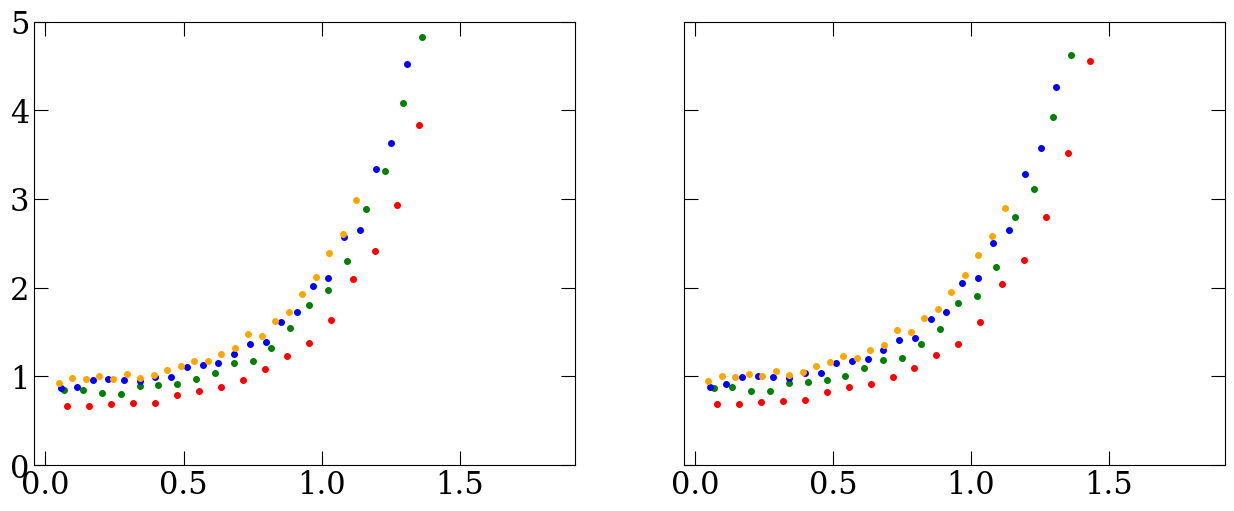

In [5]:
Nsrcs=np.array([200+85+64,650,256+112,100])
Ncfgs=np.array([743,400,494,516])
# Ncfgs=np.array([400,400,400,400])
stats=Nsrcs*Ncfgs
rescales=np.sqrt(stats/stats[1])
# rescales=[1,1,1,1]

fix, axs = yu.getFigAxs(1,2,sharey=True)
ax=axs[0,0]
ax.set_ylim([0,5])
# ax.set_ylim([900,1000])
colors=['r','g','b','orange']
for i_ens,ens in enumerate(enss):
    Ncfg=Ncfgs[i_ens]
    xunit=ens2a[ens]
    tfs=ens2tfs[ens]
    cN0=np.real(yu.jackknife(data[ens]['N0'][:Ncfg]))
    func=lambda c:np.log(c/np.roll(c,-1))
    meff=yu.jackmap(func,cN0)
    # print(meff.shape)
    
    color=colors[i_ens]
    for i_tf,tf in enumerate(range(1,24)):
        # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        mean,err=yu.jackme(meff[:,tf] * ens2aInv[ens])
        plt_y=err*rescales[i_ens]
        ax.scatter(tf*xunit,plt_y, color=color, marker='o')
        
ax=axs[0,1]
# ax.set_ylim([900,1000])
colors=['r','g','b','orange']
for i_ens,ens in enumerate(enss):
    Ncfg=Ncfgs[i_ens]
    xunit=ens2a[ens]
    tfs=ens2tfs[ens]
    cN1=np.real(yu.jackknife(data[ens]['N1'][:Ncfg]))
    func=lambda c:np.log(c/np.roll(c,-1))
    meff=yu.jackmap(func,cN1)
    
    color=colors[i_ens]
    for i_tf,tf in enumerate(range(1,24)):
        # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        mean,err=yu.jackme(meff[:,tf] * ens2aInv[ens])
        plt_y=err*rescales[i_ens]
        ax.scatter(tf*xunit,plt_y, color=color, marker='o')
        # ax.scatter(tf*xunit,plt_y, color=color, marker='o', facecolor='white')

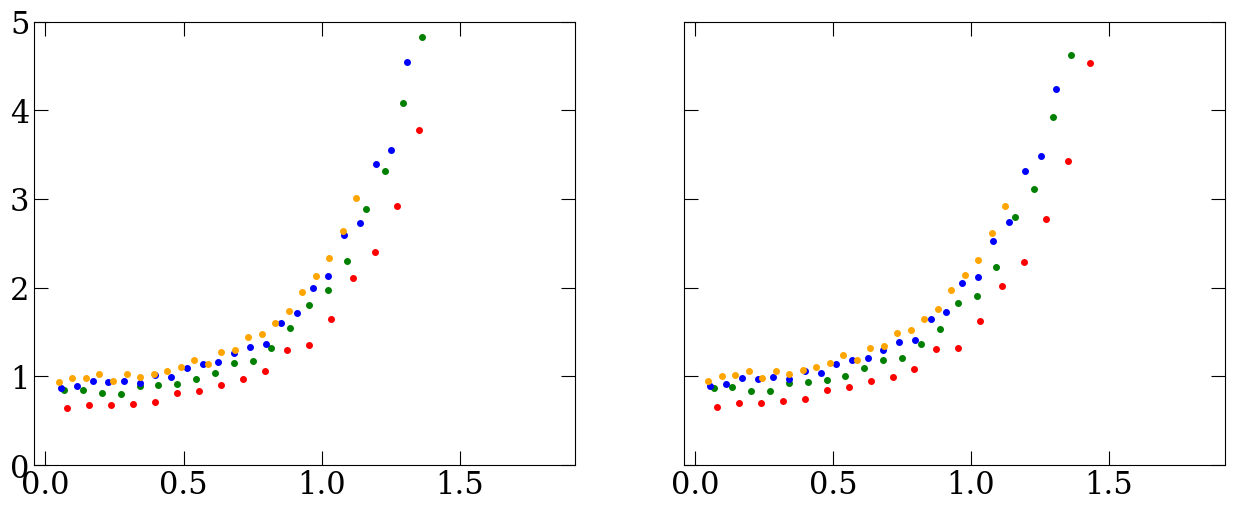

In [20]:
Nsrcs=np.array([200+85+64,650,256+112,100])
# Ncfgs=np.array([743,400,494,516])
Ncfgs=np.array([400,400,400,400])
stats=Nsrcs*Ncfgs
rescales=np.sqrt(stats/stats[1])
# rescales=[1,1,1,1]

fix, axs = yu.getFigAxs(1,2,sharey=True)
ax=axs[0,0]
ax.set_ylim([0,5])
# ax.set_ylim([900,1000])
colors=['r','g','b','orange']
for i_ens,ens in enumerate(enss):
    Ncfg=Ncfgs[i_ens]
    xunit=ens2a[ens]
    tfs=ens2tfs[ens]
    cN0=np.real(yu.jackknife(data[ens]['N0'][:Ncfg]))
    func=lambda c:np.log(c/np.roll(c,-1))
    meff=yu.jackmap(func,cN0)
    # print(meff.shape)
    
    color=colors[i_ens]
    for i_tf,tf in enumerate(range(1,24)):
        # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        mean,err=yu.jackme(meff[:,tf] * ens2aInv[ens])
        plt_y=err*rescales[i_ens]
        ax.scatter(tf*xunit,plt_y, color=color, marker='o')
        
ax=axs[0,1]
# ax.set_ylim([900,1000])
colors=['r','g','b','orange']
for i_ens,ens in enumerate(enss):
    Ncfg=Ncfgs[i_ens]
    xunit=ens2a[ens]
    tfs=ens2tfs[ens]
    cN1=np.real(yu.jackknife(data[ens]['N1'][:Ncfg]))
    func=lambda c:np.log(c/np.roll(c,-1))
    meff=yu.jackmap(func,cN1)
    
    color=colors[i_ens]
    for i_tf,tf in enumerate(range(1,24)):
        # mean,err=yu.jackme(ratioDic[tf][:,tf//2]) if tf%2==0 else yu.jackme((ratioDic[tf][:,tf//2]+ratioDic[tf][:,tf//2+1])/2)
        mean,err=yu.jackme(meff[:,tf] * ens2aInv[ens])
        plt_y=err*rescales[i_ens]
        ax.scatter(tf*xunit,plt_y, color=color, marker='o')
        # ax.scatter(tf*xunit,plt_y, color=color, marker='o', facecolor='white')

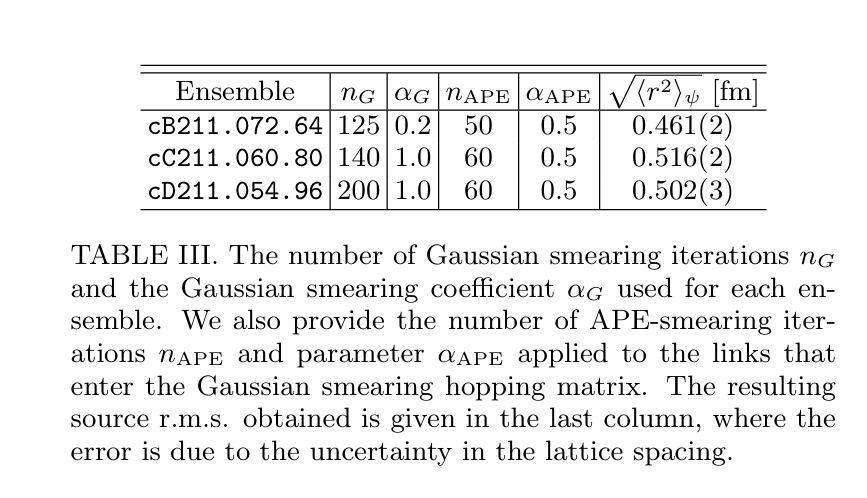

radius smaller

alpha smaller
